In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import NUTS
from pyro.infer.mcmc import MCMC
import arviz

# Part B.1

In [2]:
def f (x):
    return np.sin (20 * x) + 2 * np.cos (14 * x) - 2 * np.sin (6 * x)

x = torch.tensor ([-1, -0.5, 0, 0.5, 1])
#x = torch.linspace (-1, 1, 20)
y = f (x)
#x = x + torch.randn (x.shape) * 0.05
#print (x)


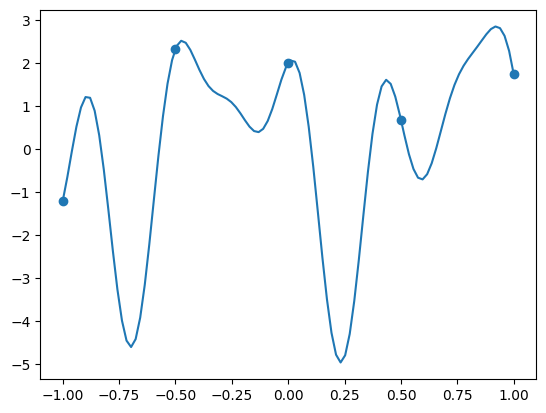

In [3]:
test_x = np.linspace (-1, 1, 100)
test_y = f (test_x)
plt.scatter (x, y)
plt.plot (test_x, test_y)
#x = torch.linspace (-1, 1, 10)
#y = torch.tensor (f (x))
#x = x + torch.randn (x.shape) * 0.05


In [4]:
def plot(
    x,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(x.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-1.2, 1.2)

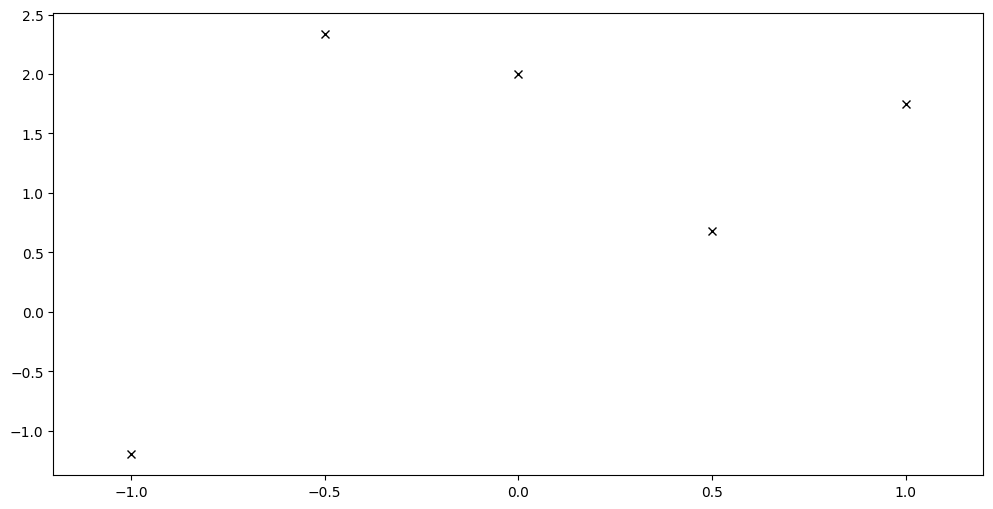

In [5]:
plot(x, y, plot_observed_data=True)

In [16]:
pyro.clear_param_store()
lengthscale = pyro.nn.PyroSample (dist.LogNormal(-1, 1))
variance = pyro.nn.PyroSample (dist.LogNormal (0, 2))
kernel = gp.kernels.RBF(
    input_dim=1#, variance=variance, lengthscale=lengthscale
)
kernel.variance = variance
kernel.lengthscale = lengthscale
#kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
#kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
gpr = gp.models.GPRegression(x, y, kernel, noise=torch.tensor(1e-4))
#plot(x, y, model=gpr, kernel=kernel, n_prior_samples=10)
#_ = plt.ylim((-8, 8))


In [17]:
#model = GP_model (x, y)
nuts_kernel = NUTS(gpr.model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=100)
mcmc.run()
samples = mcmc.get_samples()

for k, v in samples.items():
    print(k, v.shape)

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

kernel.lengthscale torch.Size([1000])
kernel.variance torch.Size([1000])


torch.Size([1000])


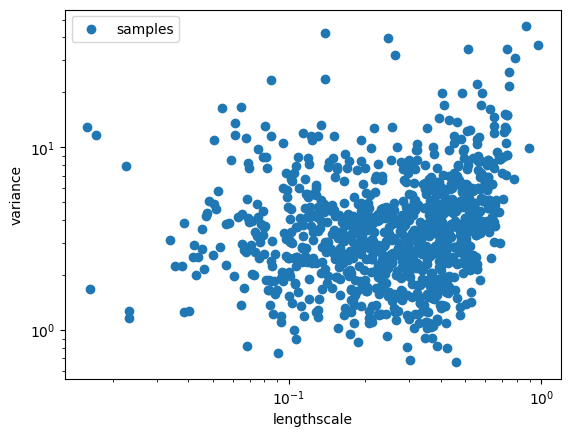

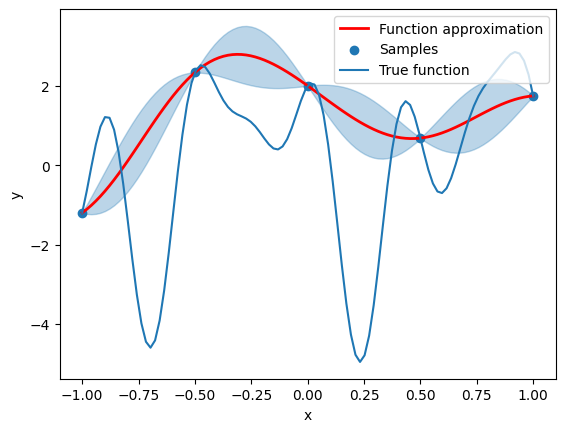

In [25]:
#plt.loglog (samples['kernel.lengthscale'], label='lengthscale')
#plt.loglog (samples['kernel.variance'], label='variance')
print (samples['kernel.lengthscale'].shape)
plt.scatter (samples['kernel.lengthscale'], samples['kernel.variance'], label="samples")
plt.xscale ('log')
plt.yscale ('log')
plt.xlabel ('lengthscale')
plt.ylabel ('variance')
plt.legend()
plt.show()

x_new = torch.linspace (-1, 1, 100)
mean, cov = gpr (x_new, full_cov=True, noiseless=False)
sd = cov.diag().sqrt()
plt.plot(x_new.detach().numpy(), mean.detach().numpy(), "r", lw=2, label="Function approximation")  
plt.fill_between(
    x_new.numpy(),  
    (mean - 2.0 * sd).detach().numpy(),
    (mean + 2.0 * sd).detach().numpy(),
    color="C0",
    alpha=0.3,
)
plt.xlabel ("x")
plt.ylabel ("y")
plt.scatter (x, y, label="Samples")
plt.plot (test_x, test_y, label="True function")
plt.legend (loc="upper right")
plt.show()

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.311  0.175   0.038    0.617      0.011    0.008   
kernel.variance     4.518  4.360   0.667   10.535      0.267    0.189   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     249.0     465.0   1.00  
kernel.variance        287.0     316.0   1.02  


c:\Program Files\Python310\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


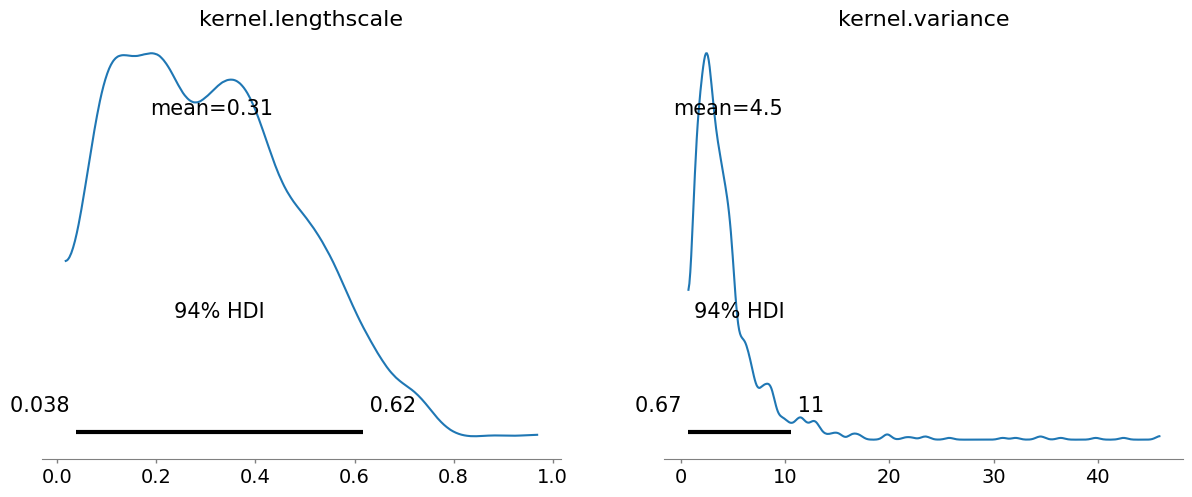

array([[<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
        <AxesSubplot: title={'center': 'kernel.lengthscale'}>],
       [<AxesSubplot: title={'center': 'kernel.variance'}>,
        <AxesSubplot: title={'center': 'kernel.variance'}>]], dtype=object)

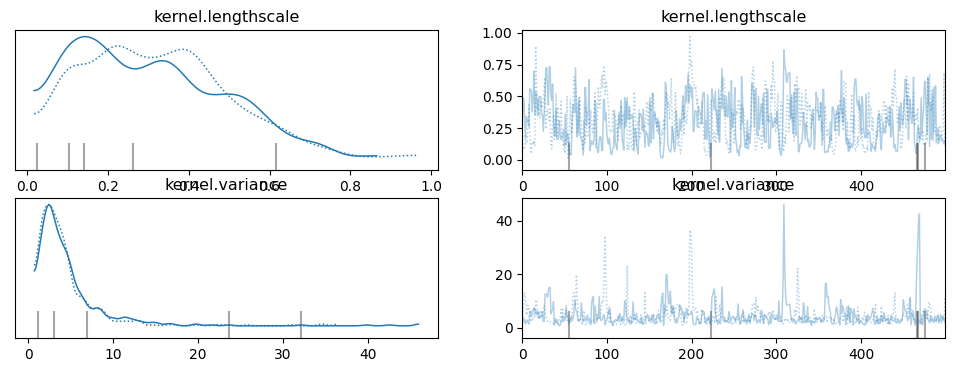

In [9]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print (summary)

arviz.plot_posterior (data, var_names=['kernel.lengthscale', 'kernel.variance'])
plt.show()
arviz.plot_trace (data, var_names=['kernel.lengthscale', 'kernel.variance'])

# Part B.2

torch.Size([2, 5])
Iteration:  1


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

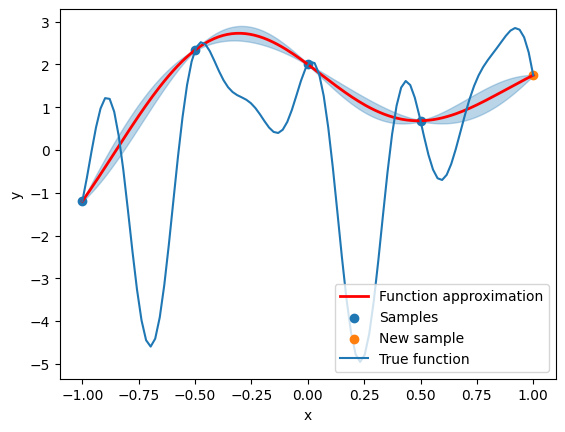

Iteration:  2


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

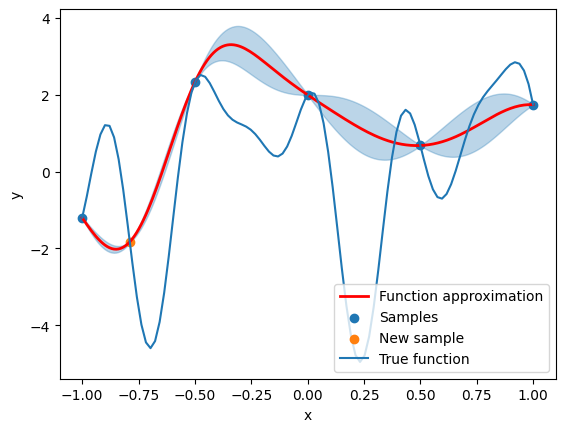

Iteration:  3


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

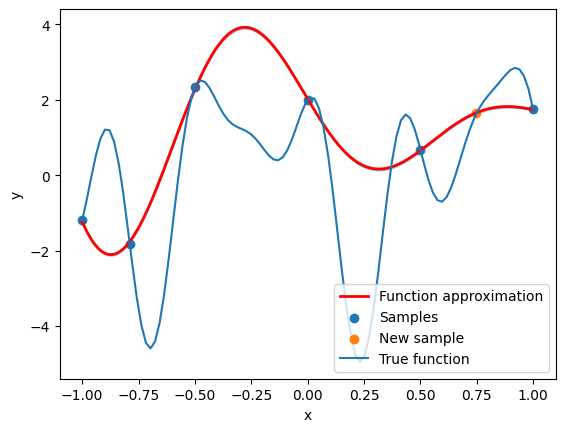

Iteration:  4


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

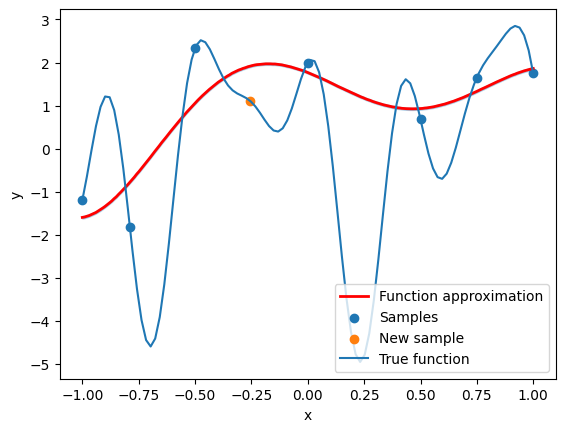

Iteration:  5


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

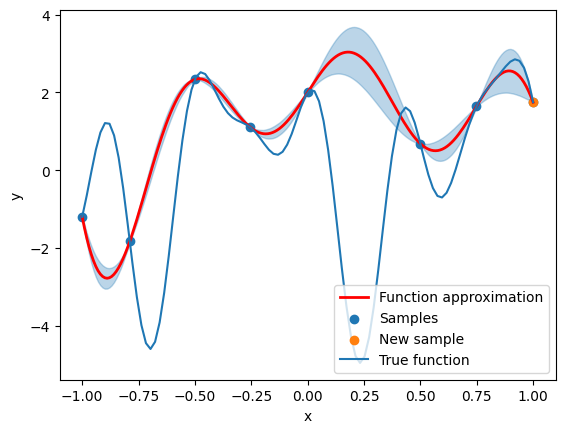

Iteration:  6


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

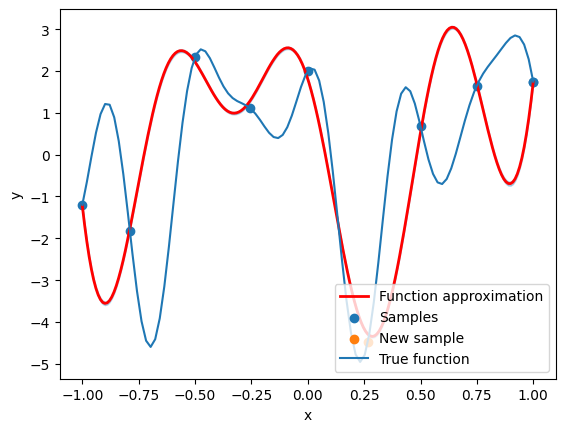

Iteration:  7


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

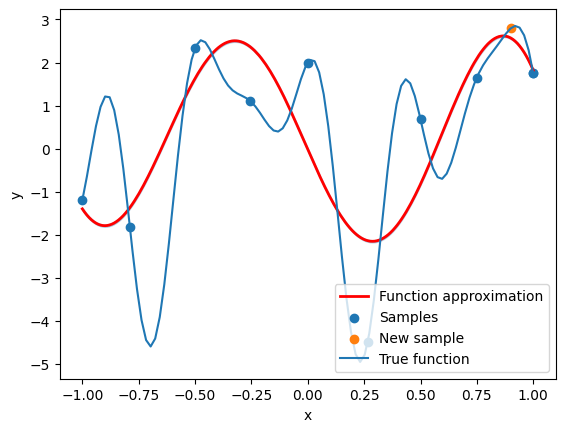

Iteration:  8


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

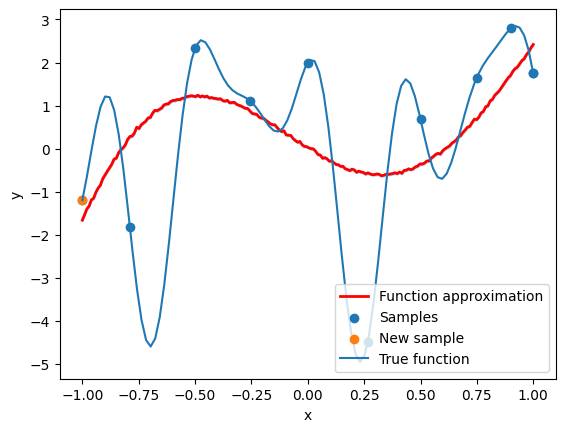

Iteration:  9


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

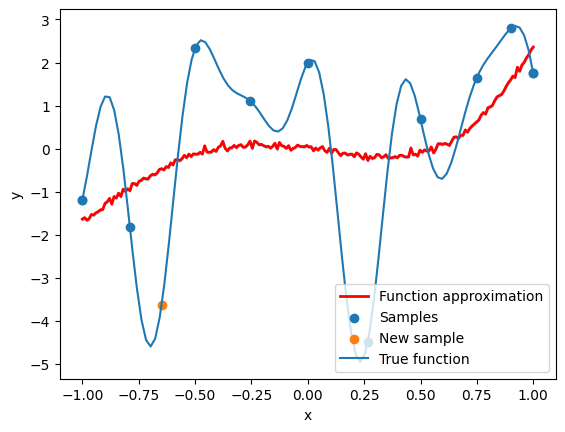

Iteration:  10


Warmup [1]:   0%|          | 0/150 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/150 [00:00, ?it/s]

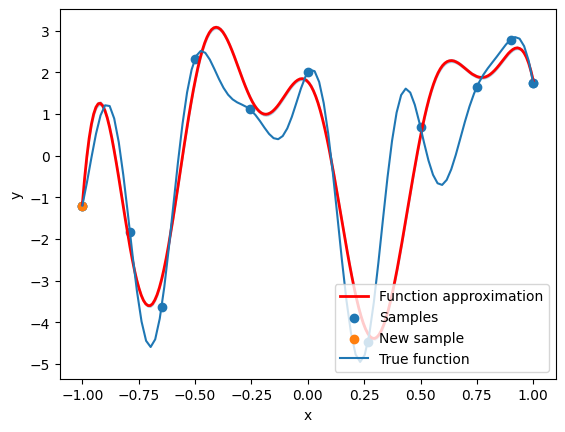

In [23]:
def bayesian_optimization (D, X_size, n_iter=10):
    X_new = torch.linspace (-1, 1, X_size)

    for k in range (n_iter):
        print ("Iteration: ", k+1)
        pyro.clear_param_store()
        lengthscale = pyro.nn.PyroSample (dist.LogNormal(-1, 1))
        variance = pyro.nn.PyroSample (dist.LogNormal (0, 2))
        kernel = gp.kernels.RBF(
            input_dim=1#, variance=variance, lengthscale=lengthscale
        )
        kernel.variance = variance
        kernel.lengthscale = lengthscale
        
        gpr = gp.models.GPRegression(D[0], D[1], kernel, noise=torch.tensor(1e-4))
        nuts_kernel = NUTS(gpr.model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
        mcmc = MCMC(nuts_kernel, num_samples=50, num_chains=2, warmup_steps=100)
        mcmc.run()
        samples = mcmc.get_samples()

        mean, cov = gpr (X_new, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt() 

        plt.plot (X_new.detach().numpy(), mean.detach().numpy(), "r", lw=2, label="Function approximation")
        plt.fill_between(
            X_new.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).detach().numpy(),
            (mean + 2.0 * sd).detach().numpy(),
            color="C0",
            alpha=0.3,
        )
        plt.scatter (D[0][:-1], D[1][:-1], label="Samples")
        plt.scatter (D[0][-1], D[1][-1], label="New sample")
        plt.plot (test_x, test_y, label="True function")
        plt.xlabel ("x")
        plt.ylabel ("y")
        plt.legend (loc="lower right")
        plt.savefig ("bayesian_optimization_" + str (k) + ".png")
        plt.show ()

        x_p = X_new [torch.argmax (sd)]
        #x_p = X_new [torch.argmin (mean)]
        y_p = f (x_p)
        D = torch.cat ((D, torch.stack ((x_p, y_p)).reshape (2, 1)), dim=1)

    return D, mean


    

D = torch.stack ((x, y))
print (D.size())
new_D, mean = bayesian_optimization (D, 200, n_iter=10)

Warmup [1]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/200 [00:00, ?it/s]

tensor([[-1.0000, -0.5000,  0.0000,  0.5000,  1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.1983,  2.3341,  2.0000,  0.6815,  1.7453, -1.1983, -1.1983, -1.1983,
         -1.1983, -1.1983, -1.1983, -1.1983, -1.1983, -1.1983, -1.1983]])
(100,)
(100,)


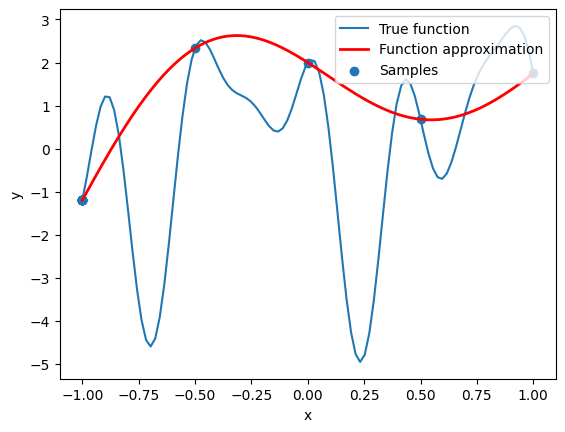

In [13]:
pyro.clear_param_store()
lengthscale = pyro.nn.PyroSample (dist.LogNormal(-1, 1))
variance = pyro.nn.PyroSample (dist.LogNormal (0, 2))
kernel = gp.kernels.RBF(
    input_dim=1#, variance=variance, lengthscale=lengthscale
)
kernel.variance = variance
kernel.lengthscale = lengthscale

gpr = gp.models.GPRegression(new_D[0], new_D[1], kernel, noise=torch.tensor(1e-4))
nuts_kernel = NUTS(gpr.model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True, target_accept_prob=0.8)
mcmc = MCMC(nuts_kernel, num_samples=100, num_chains=2, warmup_steps=100)
mcmc.run()
samples = mcmc.get_samples()

mean, cov = gpr (torch.linspace (-1, 1, 200), full_cov=True, noiseless=False)
sd = cov.diag().sqrt() 

 
print (new_D)
print (test_y.shape)
print (test_x.shape)
plt.plot (test_x, test_y, label="True function")
plt.plot (torch.linspace (-1, 1, 200), mean.detach().numpy(), "r", lw=2, label="Function approximation")
plt.scatter (new_D[0], new_D[1], label="Samples")
plt.xlabel ("x")
plt.ylabel ("y")
plt.legend (loc="upper right")
plt.show ()

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.319  0.155   0.071    0.570      0.020    0.015   
kernel.variance     4.246  4.062   1.056   13.789      0.766    0.547   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale      62.0      97.0   1.02  
kernel.variance         44.0      40.0   1.07  


c:\Program Files\Python310\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


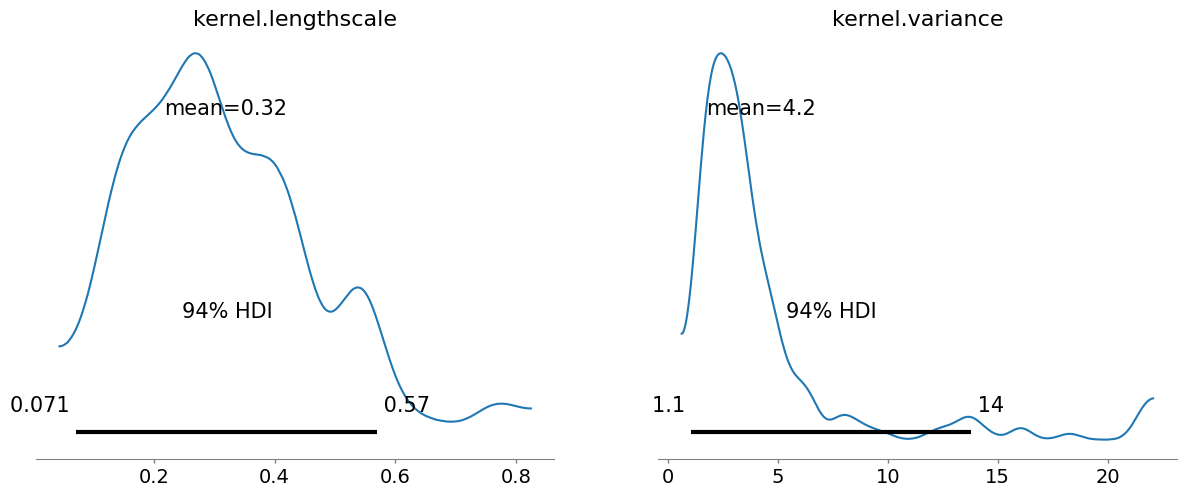

array([[<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
        <AxesSubplot: title={'center': 'kernel.lengthscale'}>],
       [<AxesSubplot: title={'center': 'kernel.variance'}>,
        <AxesSubplot: title={'center': 'kernel.variance'}>]], dtype=object)

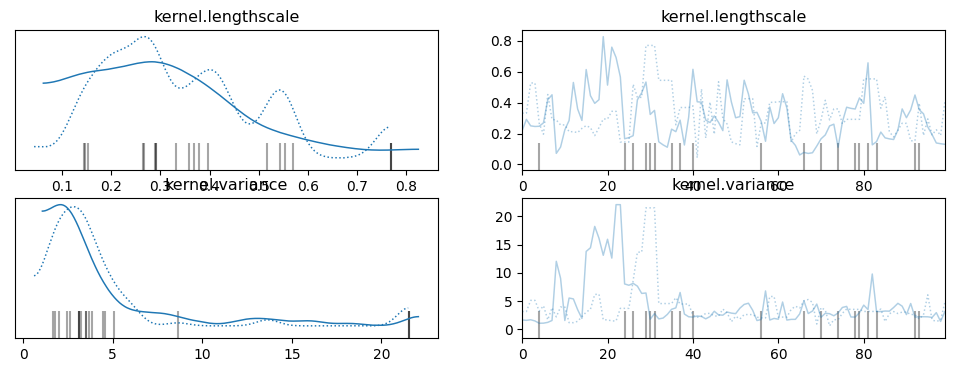

In [12]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print (summary)

arviz.plot_posterior (data, var_names=['kernel.lengthscale', 'kernel.variance'])
plt.show()
arviz.plot_trace (data, var_names=['kernel.lengthscale', 'kernel.variance'])